AutoGluon - Predicción de ventas (tn) por producto para febrero 2020

In [4]:
# 📦 1. Importar librerías
import pandas as pd

In [5]:
# 💬 Instalar AutoGluon si es necesario
#%pip install autogluon.timeseries

from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from sklearn.preprocessing import StandardScaler

c:\Users\leona\anaconda3\envs\py310lab3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# 📄 2. Cargar datasets
df_sellin = pd.read_csv("../data/sell-in.txt", sep="\t")
df_productos = pd.read_csv("../data/tb_productos.txt", sep="\t")

In [7]:
# 📄 Leer lista de productos a predecir
with open("../data/product_id_apredecir201912.txt", "r") as f:
    product_ids = [int(line.strip()) for line in f if line.strip().isdigit()]

In [8]:
# 🧹 3. Preprocesamiento
# Convertir periodo a datetime
df_sellin['timestamp'] = pd.to_datetime(df_sellin['periodo'], format='%Y%m')

In [9]:
# Filtrar hasta dic 2019 y productos requeridos
df_filtered = df_sellin[
    (df_sellin['timestamp'] <= '2019-12-01') &
    (df_sellin['product_id'].isin(product_ids))
]

In [10]:
# Agregar tn por periodo, cliente y producto
df_grouped = df_filtered.groupby(['timestamp', 'customer_id', 'product_id'], as_index=False)['tn'].sum()

In [11]:
# Agregar tn total por periodo y producto
df_monthly_product = df_grouped.groupby(['timestamp', 'product_id'], as_index=False)['tn'].sum()

In [12]:
# Agregar columna 'item_id' para AutoGluon
df_monthly_product['item_id'] = df_monthly_product['product_id']

In [13]:
# Crear características de lag y rolling
for lag in [1, 3, 6, 12]:
    df_monthly_product[f'tn_lag_{lag}'] = df_monthly_product.groupby('product_id')['tn'].shift(lag)

df_monthly_product['tn_rolling_mean_3'] = df_monthly_product.groupby('product_id')['tn'].shift(1).rolling(window=3).mean()
df_monthly_product['tn_rolling_std_3'] = df_monthly_product.groupby('product_id')['tn'].shift(1).rolling(window=3).std()

In [14]:
# Incorporar características estáticas de tb_productos
df_monthly_product = df_monthly_product.merge(df_productos, on='product_id', how='left')

# Normalizar características numéricas
scaler = StandardScaler()
numeric_cols = ['tn_lag_1', 'tn_lag_3', 'tn_lag_6', 'tn_lag_12', 'tn_rolling_mean_3', 'tn_rolling_std_3']
df_monthly_product[numeric_cols] = scaler.fit_transform(df_monthly_product[numeric_cols].fillna(0))

In [15]:
df_monthly_product

,timestamp,product_id,tn,item_id,tn_lag_1,tn_lag_3,tn_lag_6,tn_lag_12,tn_rolling_mean_3,tn_rolling_std_3,cat1,cat2,cat3,brand,sku_size
0,2017-01-01,20001,934.77222,20001,-0.404361,-0.391227,-0.369555,-0.322445,-0.433534,-0.303098,HC,ROPA LAVADO,Liquido,ARIEL,3000
1,2017-01-01,20002,550.15707,20002,-0.404361,-0.391227,-0.369555,-0.322445,-0.433534,-0.303098,HC,ROPA LAVADO,Liquido,LIMPIEX,3000
2,2017-01-01,20003,1063.45835,20003,-0.404361,-0.391227,-0.369555,-0.322445,-0.433534,-0.303098,FOODS,ADEREZOS,Mayonesa,NATURA,475
3,2017-01-01,20004,555.91614,20004,-0.404361,-0.391227,-0.369555,-0.322445,-0.433534,-0.303098,FOODS,ADEREZOS,Mayonesa,NATURA,240
4,2017-01-01,20005,494.27011,20005,-0.404361,-0.391227,-0.369555,-0.322445,-0.433534,-0.303098,FOODS,ADEREZOS,Mayonesa,NATURA,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22677,2019-12-01,21263,0.01270,21263,-0.404105,-0.391136,-0.369472,-0.321898,-0.433281,-0.303044,PC,CABELLO,SHAMPOO,VICHY,250
22678,2019-12-01,21265,0.05007,21265,-0.403841,-0.391089,-0.369126,-0.322445,-0.433178,-0.302692,PC,PIEL1,CUIDADO ESPECIAL,LANCOME,32
22679,2019-12-01,21266,0.05121,21266,-0.403832,-0.390996,-0.369116,-0.322445,-0.433064,-0.302720,PC,PIEL1,CUIDADO ESPECIAL,LANCOME,32
22680,2019-12-01,21267,0.01569,21267,-0.404042,-0.391079,-0.369062,-0.322445,-0.433041,-0.302809,PC,PIEL1,Cara,NIVEA,250


In [16]:
df_prod_static = (
    df_productos
    .rename(columns={'product_id': 'item_id'})
    .drop_duplicates(subset=['item_id'])
)  # dejamos item_id como columna

ts_data = TimeSeriesDataFrame.from_data_frame(
    df_monthly_product,
    id_column='item_id',
    timestamp_column='timestamp',
    static_features_df=df_prod_static
)


# # ⏰ 4. Crear TimeSeriesDataFrame
# ts_data = TimeSeriesDataFrame.from_data_frame(
#     df_monthly_product,
#     id_column='item_id',
#     timestamp_column='timestamp'
# )

In [17]:
# # Completar valores faltantes
ts_data = ts_data.fill_missing_values()

In [18]:
predictor = TimeSeriesPredictor(
    prediction_length=2,
    target='tn',
    freq='MS',
    eval_metric='WQL'
)

predictor.fit(
    train_data=ts_data,
    num_val_windows=2,
    time_limit=60*60
)

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'c:\Users\leona\source\repos\lab3\notebooks\AutogluonModels\ag-20250714_004102'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.17
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       11.11 GB / 31.71 GB (35.0%)
Disk Space Avail:   203.50 GB / 952.62 GB (21.4%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'MS',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'tn',
 'time_limit': 3600,
 'verbosity': 2}

train_data with frequency 'IRREG' has been resampled to frequency 'MS'.
Provided 

In [21]:
# 3.1) Sólo data como argumento
future_template = predictor.make_future_data_frame(ts_data)

# 3.2) Covariables “a mano”
future_rows = []
for item_id in product_ids:
    last = df_monthly_product[df_monthly_product['item_id']==item_id].iloc[-1]
    future_rows.append({
        'item_id': item_id,
        'timestamp': pd.Timestamp('2020-02-01'),
        'month':  2,
        'year':   2020,
        'tn_lag_1':          last['tn_lag_1'],
        'tn_lag_3':          last['tn_lag_3'],
        'tn_lag_6':          last['tn_lag_6'],
        'tn_lag_12':         last['tn_lag_12'],
        'tn_rolling_mean_3': last['tn_rolling_mean_3'],
        'tn_rolling_std_3':  last['tn_rolling_std_3'],
    })
df_future_covars = pd.DataFrame(future_rows)

# 3.3) Merge plantilla + covariables
future_covars = future_template.merge(
    df_future_covars,
    on=['item_id','timestamp'],
    how='left'
)

# 3.4) A TimeSeriesDataFrame
ts_future_covars = TimeSeriesDataFrame.from_data_frame(
    future_covars,
    id_column='item_id',
    timestamp_column='timestamp'
).fill_missing_values(method='ffill', value=0)

data with frequency 'IRREG' has been resampled to frequency 'MS'.


In [22]:
# # 🔮 6. Generar predicción
# forecast = predictor.predict(ts_data)

# 4) Predecir
forecast = predictor.predict(
    data=ts_data,
    known_covariates=ts_future_covars
)

data with frequency 'IRREG' has been resampled to frequency 'MS'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [23]:
forecast

mean         0.1          0.2          0.3  \
item_id timestamp                                                       
20001   2020-01-01  1249.019034  975.430023  1055.792350  1138.210155   
        2020-02-01  1272.924624  975.649551  1065.713587  1147.273627   
20002   2020-01-01  1047.817661  730.355895   863.678011   917.548915   
        2020-02-01  1056.173821  728.788588   845.752513   903.693635   
20003   2020-01-01   746.215089  571.098381   623.440084   657.170641   
...                         ...         ...          ...          ...   
20995   2020-02-01     2.571621    0.882548     1.495597     1.929920   
21087   2020-01-01     0.869681    0.386501     0.559447     0.685507   
        2020-02-01     0.972690    0.382928     0.599687     0.741450   
21214   2020-01-01     0.341638    0.001311     0.119461     0.206161   
        2020-02-01     0.366954   -0.067386     0.086440     0.196424   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
20001   2020-01-01  1188.258737  1256.769667  1309.808315  1369.592950   
        2020-02-01  1206.154480  1262.897341  1342.909116  1405.466430   
20002   2020-01-01   975.391885  1066.963710  1130.899179  1190.663097   
        2020-02-01   974.839922  1071.281690  1151.462224  1213.077141   
20003   2020-01-01   697.682429   741.697583   775.482384   825.644478   
...                         ...          ...          ...          ...   
20995   2020-02-01     2.259163     2.567587     2.891834     3.301575   
21087   2020-01-01     0.776351     0.868495     0.944524     1.055246   
        2020-02-01     0.854687     0.968464     1.068427     1.212056   
21214   2020-01-01     0.271452     0.340813     0.396637     0.471498   
        2020-02-01     0.287148     0.373229     0.444186     0.541204   

                            0.8          0.9  
item_id timestamp                             
20001   2020-01-01  1427.801204  1489.397833  
        2020-02-01  1493.074209  1570.006324  
20002   2020-01-01  1264.946298  1347.213481  
        2020-02-01  1302.122366  1413.264810  
20003   2020-01-01   860.971381   907.804601  
...                         ...          ...  
20995   2020-02-01     3.699952     4.251660  
21087   2020-01-01     1.166447     1.330559  
        2020-02-01     1.360721     1.614298  
21214   2020-01-01     0.556175     0.670686  
        2020-02-01     0.657169     0.811060  

[1560 rows x 10 columns]

In [24]:
predictor.leaderboard(ts_data)

data with frequency 'IRREG' has been resampled to frequency 'MS'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.187491,-0.167476,9.141819,6.204525,2.120605,13
1,ChronosFineTuned[bolt_small],-0.187503,-0.178788,1.205274,1.018958,521.514770,8
2,TemporalFusionTransformer,-0.191503,-0.173537,0.688898,0.598946,520.624465,9
3,PatchTST,-0.209386,-0.186348,0.316760,0.249846,66.963453,11
4,ChronosZeroShot[bolt_base],-0.211922,-0.190460,4.471346,4.076715,7.670864,7
5,AutoETS,-0.215147,-0.201045,2.858746,3.521974,3.467519,6
6,DeepAR,-0.216664,-0.181887,0.806085,0.797194,161.254797,10
7,DynamicOptimizedTheta,-0.221798,-0.203868,1.868283,0.783261,2.667114,5
8,DirectTabular,-0.223213,-0.227987,0.542099,1.141052,39.484890,3
9,RecursiveTabular,-0.228650,-0.213785,0.120115,0.091178,2.794929,2


data with frequency 'IRREG' has been resampled to frequency 'MS'.


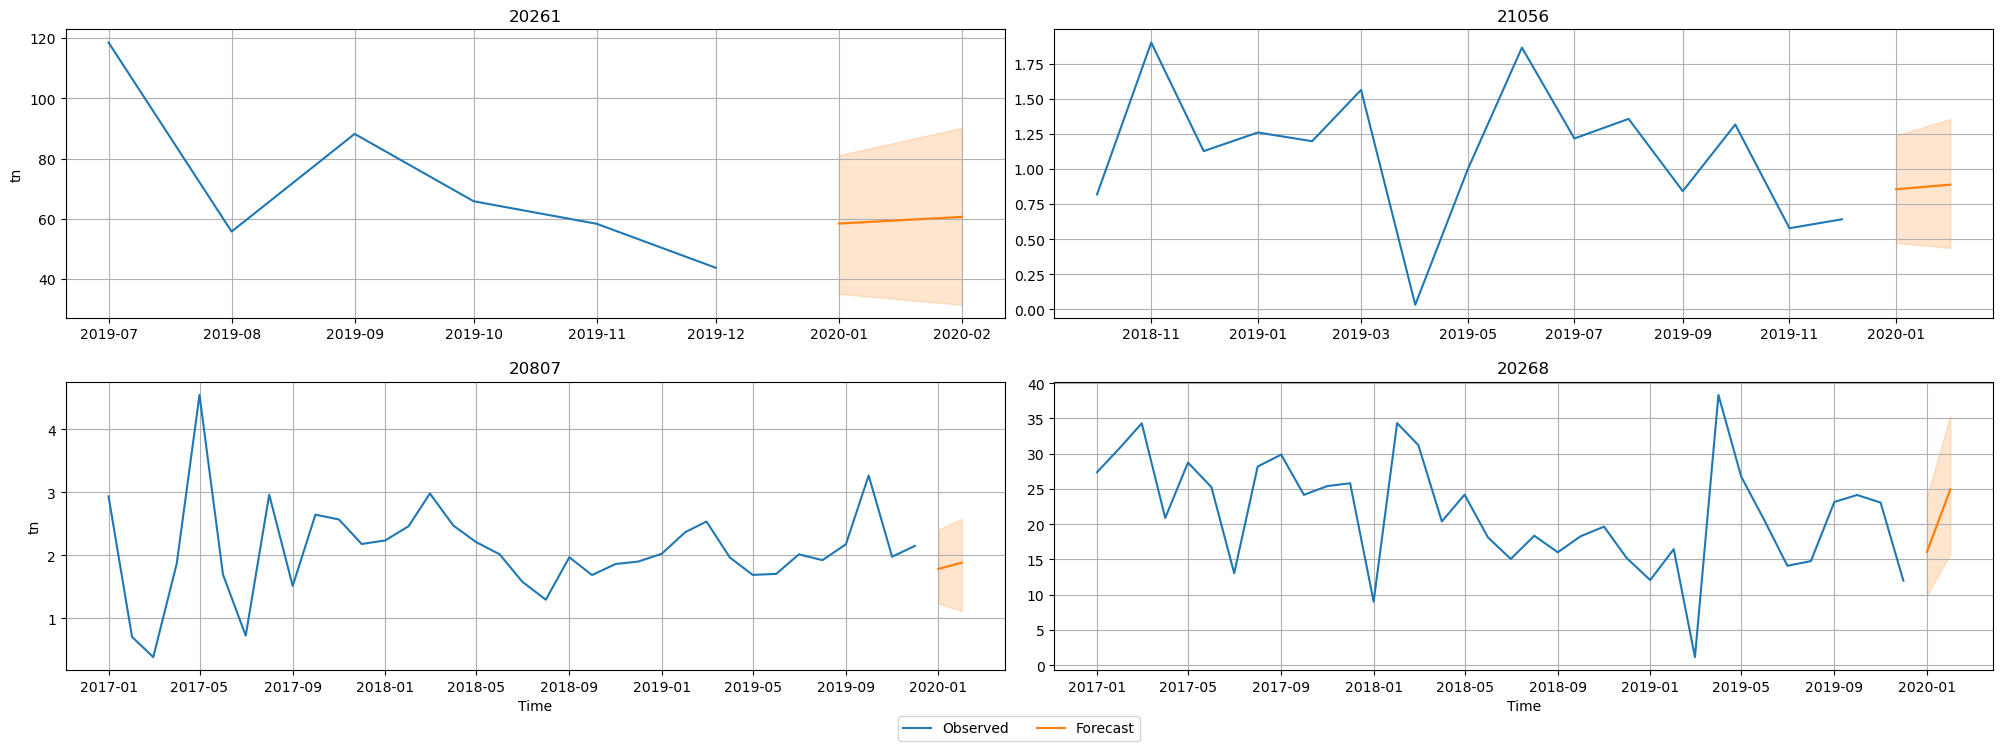

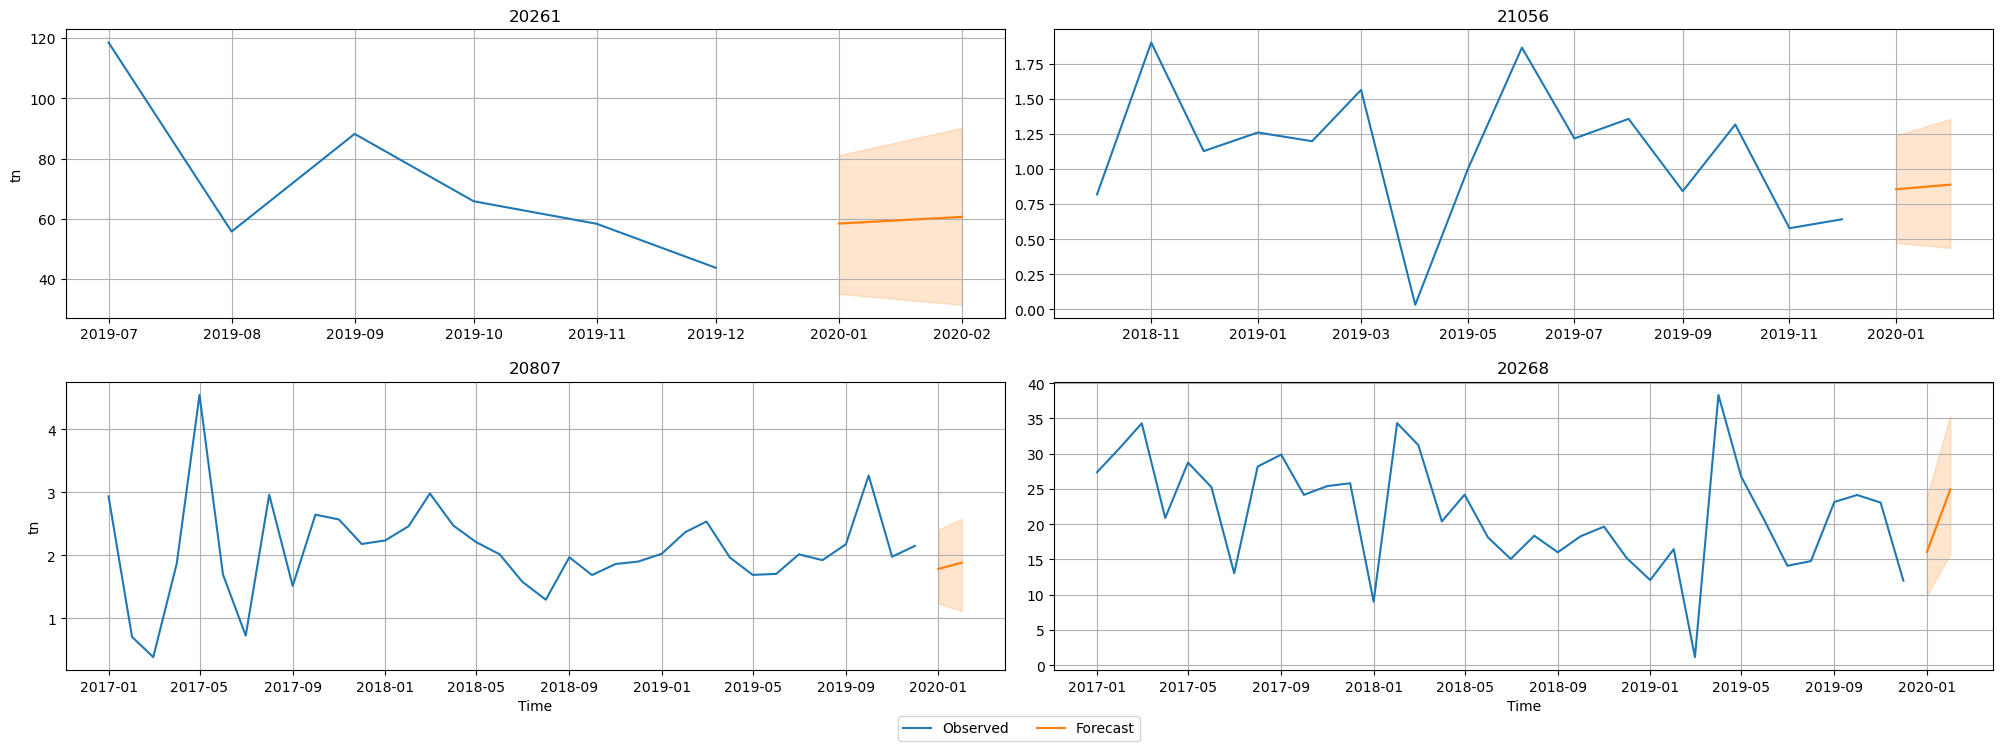

In [25]:
predictor.plot(ts_data, forecast, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4)

In [26]:
# Extraer predicción media y filtrar febrero 2020
forecast_mean = forecast['mean'].reset_index()
print(forecast_mean.columns)

Index(['item_id', 'timestamp', 'mean'], dtype='object')


In [27]:
# Tomar solo item_id y la predicción 'mean'
resultado = forecast['mean'].reset_index()[['item_id', 'mean']]
resultado.columns = ['product_id', 'tn']

# Filtrar solo febrero 2020
resultado = forecast['mean'].reset_index()
resultado = resultado[resultado['timestamp'] == '2020-02-01']

# Renombrar columnas
resultado = resultado[['item_id', 'mean']]
resultado.columns = ['product_id', 'tn']


In [28]:
resultado

,product_id,tn
1,20001,1272.924624
3,20002,1056.173821
5,20003,690.595647
7,20004,522.239401
9,20005,498.059314
...,...,...
1551,20962,3.123503
1553,20975,2.988171
1555,20995,2.571621
1557,21087,0.972690


In [61]:
# 💾 7. Guardar archivo
resultado.to_csv("../data/autogluon_202002_lhv10.csv", index=False)
resultado.head()

,product_id,tn
1,20001,1352.145783
3,20002,1080.898038
5,20003,721.620887
7,20004,534.144696
9,20005,502.292647


In [30]:
# Extraer predicción media y filtrar febrero 2020
forecast_mean = forecast['0.4'].reset_index()
print(forecast_mean.columns)

# Tomar solo item_id y la predicción 'mean'
resultado = forecast['0.4'].reset_index()[['item_id', '0.4']]
resultado.columns = ['product_id', 'tn']

# Filtrar solo febrero 2020
resultado = forecast['0.4'].reset_index()
resultado = resultado[resultado['timestamp'] == '2020-02-01']

# Renombrar columnas
resultado = resultado[['item_id', '0.4']]
resultado.columns = ['product_id', 'tn']

# 💾 7. Guardar archivo
resultado.to_csv("../data/autogluon_202002_lhv15.csv", index=False)
resultado.head()

Index(['item_id', 'timestamp', '0.4'], dtype='object')


,product_id,tn
1,20001,1206.154480
3,20002,974.839922
5,20003,647.440239
7,20004,477.924192
9,20005,458.372805


In [ ]:
# from autogluon.common import space

# # ⚙️ 5. Definir y entrenar predictor
# predictor = TimeSeriesPredictor(
#     prediction_length=2,
#     target='tn',
#     eval_metric="MASE",
#     freq='MS'  # Frecuencia mensual (Month Start), 
# )

# predictor.fit(
#     ts_data,
#     presets="best_quality",    
#     hyperparameters={
#         "DeepAR": {
#             "hidden_size": space.Int(20, 100),
#             "dropout_rate": space.Categorical(0.1, 0.3),
#         },
#         "Theta": [
#             {"decomposition_type": "additive"},
#             {"seasonal_period": 1},
#         ],
#         "Chronos": [
#             {
#                 "model_path": "bolt_small", 
#                 "ag_args": {"name_suffix": "ZeroShot"}
#             },
#             {
#                 "model_path": "bolt_small", 
#                 "fine_tune": True, 
#                 "ag_args": {"name_suffix": "FineTuned"}
#             },
#             {
#                 "model_path": "bolt_small",
#                 "covariate_regressor": "CAT",
#                 "target_scaler": "standard",
#                 "ag_args": {"name_suffix": "WithRegressor"},
#             },            
#         ]        
#     },
#     enable_ensemble=True,
#     time_limit=3600
# )

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'c:\Users\leona\source\repos\lab3\notebooks\AutogluonModels\ag-20250703_023005'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.17
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       8.57 GB / 31.71 GB (27.0%)
Disk Space Avail:   176.32 GB / 952.62 GB (18.5%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'MS',
 'hyperparameters': {'DeepAR': {},
                     'Theta': [{'decomposition_type': 'additive'},
                               {'seasonal_period': 1}]},
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_m